In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import time, datetime
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
# sys.path.append('../reproducible_figures')
# from scripts import rep_fig_vis as rfv

path_dict = loadpaths.loadpaths()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Load habitat data and selection of tiles

In [3]:
df_tile_outlines = lca.load_pols('../content/rush_tiles/rush_primaryhabitat_tiles.shp')
tile_name_col = 'PLAN_NO'
list_tile_names_to_predict = df_tile_outlines[tile_name_col].unique().tolist()
# list_tile_names_to_predict

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


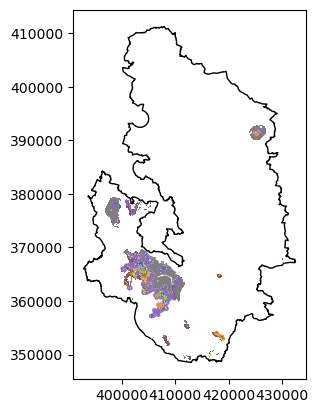

In [4]:
path_full_hab_layer = '/home/tplas/data/gis/Habitat_Networks_(England)_-_Purple_Moor_Grass_&_Rush_Pasture/Habitat_Networks_(England)_-_Purple_Moor_Grass_&_Rush_Pasture.shp'
pd_outline = lca.load_pols(path_dict['pd_outline'])
df_tile_outlines = lca.load_pols(path_dict['landscape_character_grid_path'])
df_hab_rush_full = lca.load_pols(path_full_hab_layer)

if False:
    ## Find tiles that intersect with the habitat polygons:
    df_tile_outlines['intersect'] = df_tile_outlines.intersects(df_hab_rush.unary_union)
    df_tile_outlines = df_tile_outlines[df_tile_outlines['intersect'] == True]
    print(f'Foudn {len(df_tile_outlines)} tiles that intersect with the habitat polygons')
    list_tile_names_to_predict = df_tile_outlines['PLAN_NO'].values.tolist()

## Find all polygons that are within the PD outline:
df_hab_rush_all = df_hab_rush_full[df_hab_rush_full.within(pd_outline.unary_union)]
df_hab_rush_all = df_hab_rush_all.reset_index(drop=True)

ax = plt.subplot(111)
pd_outline.plot(ax=ax, facecolor='none', edgecolor='black')
df_hab_rush_all.plot(ax=ax, column='Class', facecolor='blue', edgecolor='none')


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  


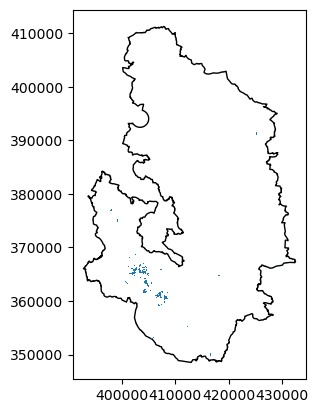

In [5]:
df_hab_rush_all = df_hab_rush_all[df_hab_rush_all['Class'] == 'Primary Habitat']
df_hab_rush_all = df_hab_rush_all.explode().reset_index(drop=True)

ax = plt.subplot(111)
pd_outline.plot(ax=ax, facecolor='none', edgecolor='black')
df_hab_rush_all.plot(ax=ax, column='Class', facecolor='blue', edgecolor='none')
# df_hab_rush

(390877.27479714615, 435005.84405727877, 345387.29766969854, 414395.0853959386)

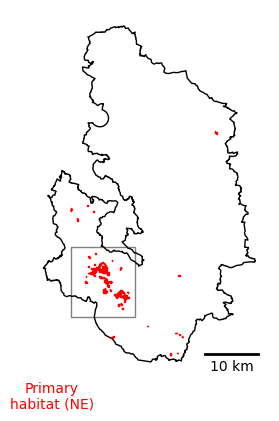

In [6]:
import shapely as shp 
ax = plt.subplot(111)
box_interest = shp.geometry.box(398000, 357000, 410000, 370000)
df_box = gpd.GeoDataFrame(geometry=[box_interest])
df_box.plot(ax=ax, facecolor='none', edgecolor='grey')
pd_outline.plot(ax=ax, facecolor='none', edgecolor='black')
df_hab_rush_all.plot(facecolor='red', edgecolor='red', ax=ax)
ax.plot([423000, 433000], [350000, 350000], c='k', linewidth=2)
ax.text(s='10 km', x=428000, y=349000, ha='center', va='top')
# ax.plot([392000, 394000], [345000, 345000], c='red', linewidth=1)
ax.text(s='Primary\nhabitat (NE)', x=394500, y=345000, ha='center', va='top', c='red')

ax.axis('off')

## Load model predictions (v1):
Here, only tiles that intersect with the NE primary habitat were predicted. So all predictions are loaded and then F3d polygons are selected.

In [7]:
df_pred_d = lca.load_pols('/home/tplas/predictions/predictions_LCU_2023-03-26-0209_dissolved100m2_clipped2_padding44/merged_tiles_predictions_LCU_2023-03-26-0209_dissolved100m2_clipped2_padding44/merged_tiles_predictions_LCU_2023-03-26-0209_dissolved100m2_clipped2_padding44.shp')
df_pred_e = lca.load_pols('/home/tplas/predictions/predictions_LCU_2023-03-26-1813_dissolved100m2_clipped3_padding44/merged_tiles_predictions_LCU_2023-03-26-1813_dissolved100m2_clipped3_padding44/merged_tiles_predictions_LCU_2023-03-26-1813_dissolved100m2_clipped3_padding44.shp')
df_pred_concat = pd.concat([df_pred_d, df_pred_e], axis=0)
df_pred_concat = df_pred_concat[df_pred_concat['Class name'] != 'NO CLASS']
df_pred_concat = df_pred_concat.drop(columns=['class'])  # overloaded when using multiple models
df_pred_concat = df_pred_concat.reset_index(drop=True)
df_pred_concat.head()

,Class name,area,polygon_id,geometry
0,Upland Heath,393.125000,3.0,"POLYGON ((403037.375 365039.500, 403037.250 36..."
1,Upland Heath,5404.578125,4.0,"POLYGON ((403104.500 365000.625, 403104.625 36..."
2,Upland Heath,282.390625,5.0,"POLYGON ((403142.500 365123.625, 403142.375 36..."
3,Upland Heath,351.734375,6.0,"POLYGON ((403001.875 365353.875, 403002.000 36..."
4,Upland Heath,601.609375,7.0,"POLYGON ((403041.250 365383.625, 403041.250 36..."


In [8]:
class_interest = 'Wetland, Wet Grassland and Rush Pasture'
df_pred_concat = df_pred_concat[df_pred_concat['Class name'] == class_interest]
df_pred_concat = df_pred_concat[df_pred_concat.within(box_interest)]
df_pred_concat = df_pred_concat.reset_index(drop=True)  
print(f'Found {len(df_pred_concat)} polygons of class {class_interest}')

Found 3468 polygons of class Wetland, Wet Grassland and Rush Pasture


## Load model predictions (v2)
This time, load from predictions of entire PDNPA and only select F3d polygons.

In [7]:
def load_f3d_section(shp_file, class_interest = 'Wetland, Wet Grassland and Rush Pasture', 
                     box_interest = shp.geometry.box(398000, 357000, 410000, 370000)):
    df = lca.load_pols(shp_file)
    # unary_bound = df.unary_union.bounds
    coords = df.bounds.minx.min(), df.bounds.maxx.max(), df.bounds.miny.min(), df.bounds.maxy.max()
    box_df= shp.geometry.box(*coords)
    
    ## if there is no overlap, return empty dataframe:
    if not box_interest.intersects(box_df):
        return None
    df = df[df['Class name'] == class_interest]
    df = df[df.within(box_interest)]
    df = df.drop(columns=['class'])  # overloaded when using multiple models
    df = df.reset_index(drop=True)
    return df

class_interest = 'Wetland, Wet Grassland and Rush Pasture'
bool_df_undefined = True
folder_sections_preds = '/media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/merged_tiles_100kmsections'
list_sections = [x for x in os.listdir(folder_sections_preds) if x[:7] == 'merged_']
for i_sec, sec_name in tqdm(enumerate(list_sections)):
    df_sec = load_f3d_section(os.path.join(folder_sections_preds, sec_name),
                              box_interest=box_interest,
                              class_interest=class_interest)
    # assert False
    if df_sec is not None:
        if bool_df_undefined:
            df_pred_concat = df_sec
            bool_df_undefined = False
        else:
            df_pred_concat = pd.concat([df_pred_concat, df_sec], axis=0)

df_pred_concat = df_pred_concat.reset_index(drop=True)
print(f'Found {len(df_pred_concat)} polygons of class {class_interest}')


26it [03:12,  7.41s/it]

Found 7940 polygons of class Wetland, Wet Grassland and Rush Pasture


## Perform analysis

In [8]:
df_hab_rush = df_hab_rush_all[df_hab_rush_all.within(box_interest)]
assert (df_hab_rush['Class'] == 'Primary Habitat').all()
print(f'Found {len(df_hab_rush)} polygons of class {class_interest}')
df_hab_rush = df_hab_rush.reset_index(drop=True)
df_hab_rush.head()

Found 34 polygons of class Wetland, Wet Grassland and Rush Pasture


,Class,GlobalID,geometry
0,Primary Habitat,e24725c0-7337-4c12-b764-80a874c45eb0,"POLYGON ((405550.000 363025.000, 405525.000 36..."
1,Primary Habitat,10f60ae5-bd74-44bb-95d9-fb2a7e06fa46,"POLYGON ((401425.000 366275.000, 401375.000 36..."
2,Primary Habitat,f5ede18b-c393-4b53-9bde-988f97cebba7,"POLYGON ((403450.000 364300.000, 403450.000 36..."
3,Primary Habitat,e61e9550-8f28-4b57-b696-565a74e97066,"POLYGON ((406375.000 361150.000, 406375.000 36..."
4,Primary Habitat,e61e9550-8f28-4b57-b696-565a74e97066,"POLYGON ((406375.000 360800.000, 406350.000 36..."


In [16]:
dist_mat_up

array([100.51187928, 150.00098923, 116.66075788, 113.80384368,
       105.03265631, 122.5727737 , 160.82653003, 114.71540026,
       161.44588437, 201.87510832, 193.72894102, 222.1720823 ,
       259.65686178, 108.43286958, 262.71197609, 184.75934154,
       236.13754164, 295.22895573, 203.07368379,  85.85181175,
       143.75739809, 210.82080818, 138.43052384,  99.71833036,
        76.8160974 ,  58.79251844, 127.6480604 ,  69.37535341])

In [13]:
dict_rush_in_hab = {} 
dict_stats_per_hab = {x: [] for x in ['GlobalID', 'area_hab', 'area_pred', 'perc_pred_in_hab',
                                      'n_pred_patches', 'av_area_pred_patch', 'av_global_isolation',
                                      'av_nearest_neighbour', 'proximity_index', 'total_edge_length',
                                      'total_edge_length_per_area_hab', 'total_edge_length_per_area_pred',
                                      'area_pred_in_buffer', 'area_pred_in_buffer_per_area_hab',
                                      'hab_edge_length']}
distance_method = 'centroids'
buffer_dist = 50
pd.options.mode.chained_assignment = None  # default='warn'
for i in tqdm(range(len(df_hab_rush))):
    name_hab = df_hab_rush.loc[i, 'GlobalID']
    pol_hab = df_hab_rush.loc[i, 'geometry']
    pol_hab_buffer = pol_hab.buffer(buffer_dist).difference(pol_hab)
    df_intersect_bufer = df_pred_concat[df_pred_concat.intersects(pol_hab_buffer)]
    df_intersect_bufer['geometry'] = df_intersect_bufer.intersection(pol_hab_buffer)

    df_intersect = df_pred_concat[df_pred_concat.intersects(pol_hab)]
    df_intersect['geometry'] = df_intersect.intersection(pol_hab)
    df_intersect = df_intersect.reset_index(drop=True)
    dict_rush_in_hab[name_hab] = df_intersect
    n_pols_pred = len(df_intersect)

    ## Calculate stats:
    dict_stats_per_hab['GlobalID'].append(name_hab)
    dict_stats_per_hab['area_hab'].append(pol_hab.area / 1e6)
    dict_stats_per_hab['area_pred'].append(df_intersect['geometry'].area.sum() / 1e6)
    dict_stats_per_hab['perc_pred_in_hab'].append(dict_stats_per_hab['area_pred'][-1] / dict_stats_per_hab['area_hab'][-1])
    dict_stats_per_hab['n_pred_patches'].append(n_pols_pred)
    dict_stats_per_hab['av_area_pred_patch'].append(df_intersect['geometry'].area.mean() / 1e6 if len(df_intersect) > 0 else np.nan)
    dict_stats_per_hab['hab_edge_length'].append(pol_hab.length / 1e3)
    ## BUffer stats
    dict_stats_per_hab['area_pred_in_buffer'].append(df_intersect_bufer['geometry'].area.sum() / 1e6)
    dict_stats_per_hab['area_pred_in_buffer_per_area_hab'].append(dict_stats_per_hab['area_pred_in_buffer'][-1] / dict_stats_per_hab['area_hab'][-1])

    # if name_hab == curr_key:
    if n_pols_pred == 0:
        for name_col in ['av_global_isolation', 'av_nearest_neighbour', 'proximity_index',
                         'total_edge_length',
                                      'total_edge_length_per_area_hab', 'total_edge_length_per_area_pred']:
            dict_stats_per_hab[name_col].append(np.nan) 
        
    else:
        dist_mat = np.zeros((n_pols_pred, n_pols_pred))
        for i in range(n_pols_pred):
            if distance_method == 'polygons':
                dist_mat[i, :] = df_intersect['geometry'].distance(df_intersect['geometry'].iloc[i])
            elif distance_method == 'centroids':
                dist_mat[i, :] = df_intersect['geometry'].centroid.distance(df_intersect['geometry'].iloc[i].centroid)

        ## get upper triangle of distance matrix:
        dist_mat_up = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
        np.fill_diagonal(dist_mat, np.nan)
        arr_nn = np.nanmin(dist_mat, axis=1)
        if n_pols_pred == 1:
            mean_nn = np.nan 
        else:
            mean_nn = arr_nn.mean()
        dict_stats_per_hab['av_global_isolation'].append(dist_mat_up.mean() / 1e3)
        dict_stats_per_hab['av_nearest_neighbour'].append(mean_nn / 1e3)
        dict_stats_per_hab['proximity_index'].append(dict_stats_per_hab['area_pred'][-1] / dict_stats_per_hab['av_nearest_neighbour'][-1])

        ## Calculate edge length:
        df_intersect['edge_length'] = df_intersect['geometry'].length / 1e3  # in km
        dict_stats_per_hab['total_edge_length'].append(df_intersect['edge_length'].sum())  # in km
        dict_stats_per_hab['total_edge_length_per_area_hab'].append(dict_stats_per_hab['total_edge_length'][-1] / dict_stats_per_hab['area_hab'][-1])  
        dict_stats_per_hab['total_edge_length_per_area_pred'].append(dict_stats_per_hab['total_edge_length'][-1] / dict_stats_per_hab['area_pred'][-1])

df_stats_per_hab = pd.DataFrame(dict_stats_per_hab)

  0%|          | 0/34 [00:00<?, ?it/s]

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: All-NaN slice encountered
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice.
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 53%|█████▎    | 18/34 [00:07<00:07,  2.26it/s]/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: All-NaN slice encountered
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice.
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 76%|███████▋  | 26/34 [00:09<00:02,  3.11it/s]/home/tplas/anaconda3/envs/geo/lib/pytho

In [11]:
# pol_hab_buffer

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


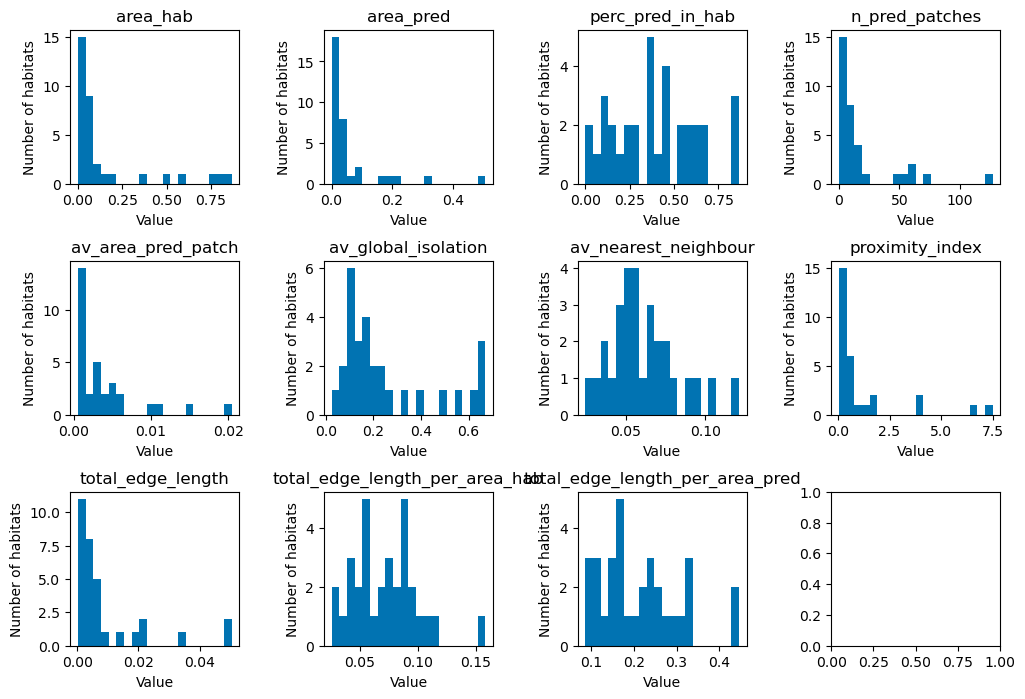

In [23]:
plot_cols = ['area_hab', 'area_pred', 'perc_pred_in_hab',
            'n_pred_patches', 'av_area_pred_patch', 'av_global_isolation',
            'av_nearest_neighbour', 'proximity_index',
            'total_edge_length',
                                      'total_edge_length_per_area_hab', 'total_edge_length_per_area_pred']

fig, ax = plt.subplots(3, 4, figsize=(12, 8), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
for i, col in enumerate(plot_cols):
    ax[i // 4, i % 4].hist(df_stats_per_hab[col], bins=20)
    ax[i // 4, i % 4].set_title(col)
    ax[i // 4, i % 4].set_xlabel('Value')
    ax[i // 4, i % 4].set_ylabel('Number of habitats')

Text(0, 0.5, 'Proximity index')

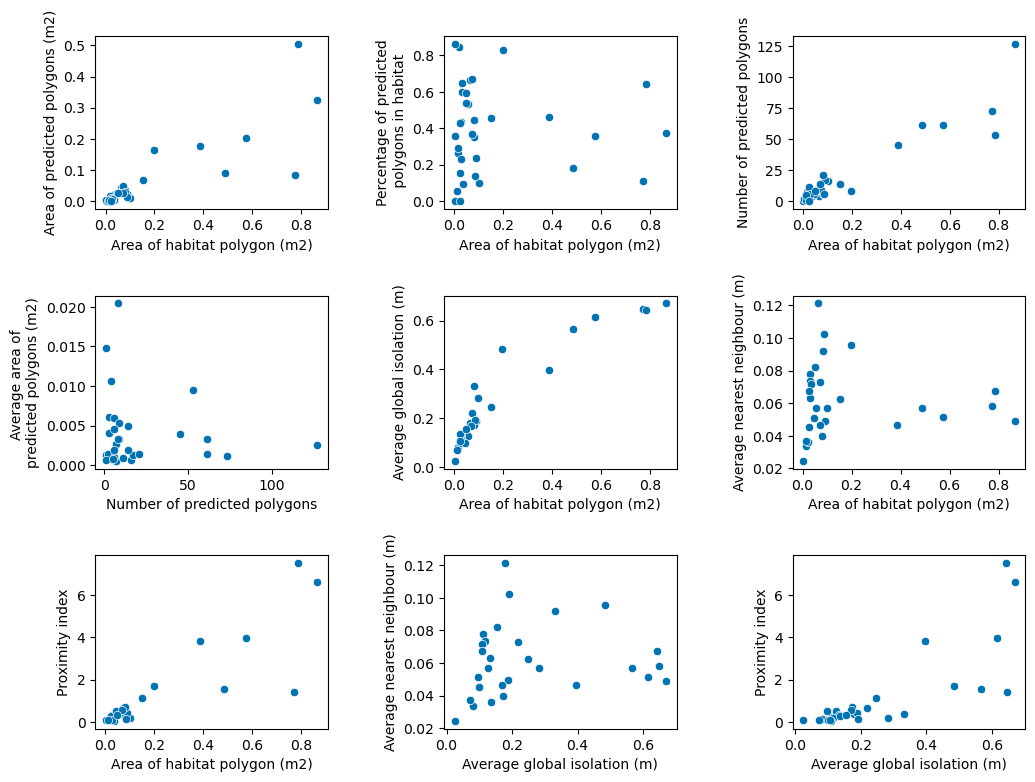

In [24]:

fig, ax = plt.subplots(3, 3, figsize=(12, 9), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})

# ax.scatter(df_stats_per_hab['area_hab'], df_stats_per_hab['area_pred'])
import seaborn as sns 

sns.scatterplot(x='area_hab', y='area_pred', data=df_stats_per_hab, ax=ax[0, 0])
ax[0, 0].set_xlabel('Area of habitat polygon (m2)')
ax[0, 0].set_ylabel('Area of predicted polygons (m2)')
# ax[0, 0].set_title('Area of habitat vs. predicted polygons')

sns.scatterplot(x='area_hab', y='perc_pred_in_hab', data=df_stats_per_hab, ax=ax[0, 1])
ax[0, 1].set_xlabel('Area of habitat polygon (m2)')
ax[0, 1].set_ylabel('Percentage of predicted\n polygons in habitat')
# ax[0, 1].set_title('Area of habitat vs. percentage\nof predicted polygons in habitat')

sns.scatterplot(x='area_hab', y='n_pred_patches', data=df_stats_per_hab, ax=ax[0, 2])
ax[0, 2].set_xlabel('Area of habitat polygon (m2)')
ax[0, 2].set_ylabel('Number of predicted polygons')
# ax[0, 2].set_title('Area of habitat vs. number of \npredicted polygons')

sns.scatterplot(x='n_pred_patches', y='av_area_pred_patch', data=df_stats_per_hab, ax=ax[1, 0])
ax[1, 0].set_xlabel('Number of predicted polygons')
ax[1, 0].set_ylabel('Average area of \npredicted polygons (m2)')
# ax[1, 0].set_title('Number of predicted polygons vs. \naverage area of predicted polygons')

sns.scatterplot(x='area_hab', y='av_global_isolation', data=df_stats_per_hab, ax=ax[1, 1])
ax[1, 1].set_xlabel('Area of habitat polygon (m2)')
ax[1, 1].set_ylabel('Average global isolation (m)')
# ax[1, 1].set_title('Area of habitat vs. average \nglobal isolation')

sns.scatterplot(x='area_hab', y='av_nearest_neighbour', data=df_stats_per_hab, ax=ax[1, 2])
ax[1, 2].set_xlabel('Area of habitat polygon (m2)')
ax[1, 2].set_ylabel('Average nearest neighbour (m)')
# ax[1, 2].set_title('Area of habitat vs. average \nnearest neighbour')

sns.scatterplot(x='area_hab', y='proximity_index', data=df_stats_per_hab, ax=ax[2, 0])
ax[2, 0].set_xlabel('Area of habitat polygon (m2)')
ax[2, 0].set_ylabel('Proximity index')
# ax[2, 0].set_title('Area of habitat vs. proximity index')

sns.scatterplot(x='av_global_isolation', y='av_nearest_neighbour', data=df_stats_per_hab, ax=ax[2, 1])
ax[2, 1].set_xlabel('Average global isolation (m)')
ax[2, 1].set_ylabel('Average nearest neighbour (m)')
# ax[2, 1].set_title('Average global isolation vs. \naverage nearest neighbour')

sns.scatterplot(x='av_global_isolation', y='proximity_index', data=df_stats_per_hab, ax=ax[2, 2])
ax[2, 2].set_xlabel('Average global isolation (m)')
ax[2, 2].set_ylabel('Proximity index')
# ax[2, 2].set_title('Average global isolation vs.\n proximity index')



In [10]:
keys_habs = df_hab_rush['GlobalID'].values.tolist()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


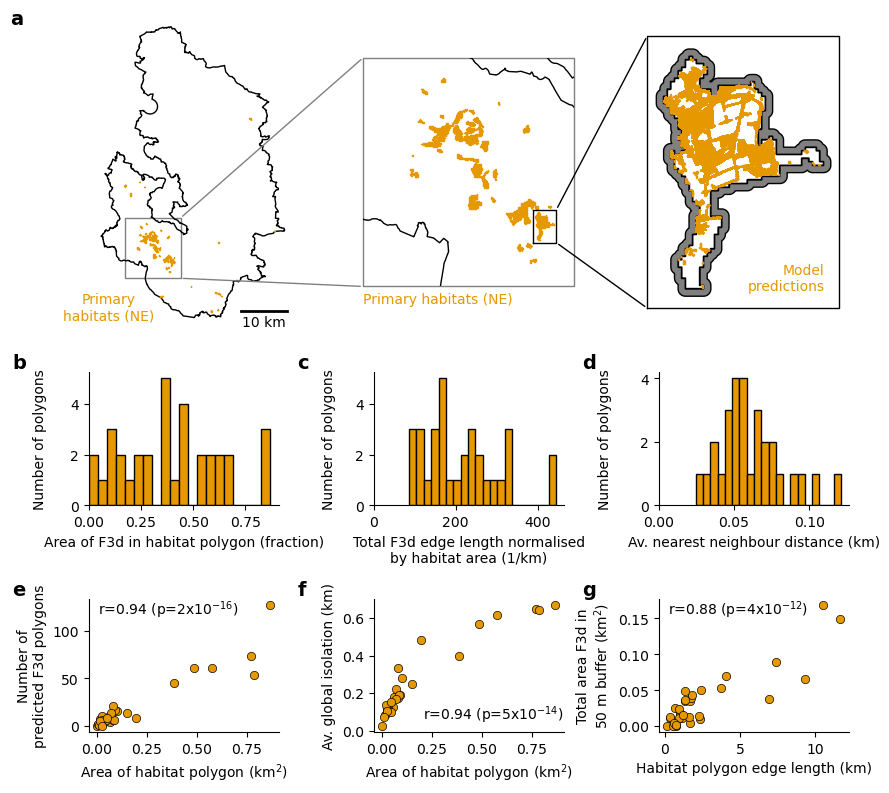

In [23]:
save_fig = True 

colour_rush = '#e69800'
plot_connecting_lines = True

fig = plt.figure(figsize=(8, 8), constrained_layout=False)
# gs_pd = fig.add_gridspec(1, 2, wspace=0.1, hspace=0.1, left=0.02, right=0.55, top=0.95, bottom=0.55)
# gs_hab_ex = fig.add_gridspec(1, 1, wspace=0.1, hspace=0.1, left=0.65, right=0.97, top=0.95, bottom=0.55)
gs_pd = fig.add_gridspec(1, 3, wspace=0.3, hspace=0.1, left=0.02, right=0.97, top=0.95, bottom=0.55)
gs_stats = fig.add_gridspec(2, 3, wspace=0.5, hspace=0.7, left=0.02, right=0.97, top=0.5, bottom=0.05)

box_minx = 398000
box_maxx = 410000
box_miny = 357000
box_maxy = 370000
axes_pd = [fig.add_subplot(gs_pd[0, iax]) for iax in range(3)]
for iax, ax in enumerate(axes_pd[:2]):
    box_interest = shp.geometry.box(box_minx, box_miny, box_maxx, box_maxy)
    df_box = gpd.GeoDataFrame(geometry=[box_interest])
    df_box.plot(ax=ax, facecolor='none', edgecolor='grey', clip_on=False)
    pd_outline.plot(ax=ax, facecolor='none', edgecolor='black')
    df_hab_rush_all.plot(facecolor=colour_rush, edgecolor=colour_rush, ax=ax)
    if iax == 0:
        ax.plot([423000, 433000], [350000, 350000], c='k', linewidth=2)
        ax.text(s='10 km', x=428000, y=349000, ha='center', va='top')
        ax.text(s='Primary\nhabitats (NE)', x=394500, y=354000, ha='center', va='top', c=colour_rush)
    elif iax == 1:
        ax.set_xlim(box_minx, box_maxx)
        ax.set_ylim(box_miny, box_maxy)
        ax.text(s='Primary habitats (NE)', x=box_minx, y=box_miny - 300, ha='left', va='top', c=colour_rush)
    ax.axis('off')

# id += 1
# curr_key = keys_habs[id]
curr_key = '5bcf3d13-da6e-4335-96a7-ce87ee5a16a2'
ax_hab_ex = fig.add_subplot(gs_pd[0, 2])
buffer_zone = df_hab_rush[df_hab_rush['GlobalID'] == curr_key].buffer(buffer_dist).difference(df_hab_rush[df_hab_rush['GlobalID'] == curr_key])
buffer_zone.plot(facecolor='gray', edgecolor='black', ax=ax_hab_ex)
df_hab_rush[df_hab_rush['GlobalID'] == curr_key].plot(facecolor='none', edgecolor='black', ax=ax_hab_ex)
dict_rush_in_hab[curr_key].plot(facecolor=colour_rush, edgecolor=colour_rush, ax=ax_hab_ex)
xlims = ax_hab_ex.get_xlim()
ylims = ax_hab_ex.get_ylim()
for ax in [axes_pd[1], ax_hab_ex]:
    ax.plot([xlims[0], xlims[1], xlims[1], xlims[0], xlims[0]], [ylims[0], ylims[0], ylims[1], ylims[1], ylims[0]], 
            c='k', linewidth=1, clip_on=False)
ax_hab_ex.axis('off')
ax_hab_ex.text(s='Model\npredictions', x=xlims[1]- 100, y=ylims[0] + 100, ha='right', va='bottom', c=colour_rush)

if plot_connecting_lines:
    ## from #https://stackoverflow.com/questions/18571474/matplotlib-can-a-plot-a-line-from-one-set-of-axes-to-another
    for ycoord in [box_miny, box_maxy]:
       axes_pd[0].annotate('', xy=(box_maxx, ycoord), xytext=(box_minx, ycoord), 
                xycoords=axes_pd[0].transData, 
                textcoords=axes_pd[1].transData, 
                arrowprops=dict(facecolor='none', edgecolor='grey',  
                                arrowstyle='-', clip_on=False))

    for ycoord in [ylims[0], ylims[1]]:
       axes_pd[1].annotate('', xy=(xlims[1], ycoord), xytext=(xlims[0], ycoord), 
                xycoords=axes_pd[1].transData, 
                textcoords=axes_pd[2].transData, 
                arrowprops=dict(facecolor='none', edgecolor='k', linewidth=1,  
                                arrowstyle='-', clip_on=False))

dict_real_names = {'perc_pred_in_hab': 'Area of F3d in habitat polygon (fraction)',
                   'total_edge_length_per_area_pred': 'Total F3d edge length normalised\nby habitat area (1/km)',
                   'av_nearest_neighbour': 'Av. nearest neighbour distance (km)',
                   'area_pred_in_buffer': f'Area of F3d in {buffer_dist} m buffer (km$^2$)',
                   'area_pred_in_buffer_per_area_hab': f'Area of F3d in {buffer_dist} m buffer\nnormalised by habitat area (fraction)'}

axes_stats = [[fig.add_subplot(gs_stats[irow, icol]) for icol in range(3)] for irow in range(2)]
for ii, col_name in enumerate(['perc_pred_in_hab', 'total_edge_length_per_area_pred', 'av_nearest_neighbour']):
# for ii, col_name in enumerate(['perc_pred_in_hab', 'area_pred_in_buffer', 'area_pred_in_buffer_per_area_hab']):
    curr_ax = axes_stats[0][ii]
    curr_ax.hist(df_stats_per_hab[col_name], bins=20, facecolor=colour_rush, edgecolor='k')
    curr_ax.set_xlabel(dict_real_names[col_name])
    curr_ax.set_ylabel('Number of polygons')
    # ## compute coef of variation:
    # cv = np.std(df_stats_per_hab[col_name]) / np.mean(df_stats_per_hab[col_name])
    # curr_ax.text(1, 1, 'CV={:.2f}'.format(cv), transform=curr_ax.transAxes, ha='right', va='top')
    ## start xlim at 0:
    curr_ax.set_xlim(0, curr_ax.get_xlim()[1])

sns.scatterplot(x='area_hab', y='n_pred_patches', data=df_stats_per_hab, ax=axes_stats[1][0],
                facecolor=colour_rush, edgecolor='k')
axes_stats[1][0].set_xlabel('Area of habitat polygon (km' + r"$^2$" + ')')
axes_stats[1][0].set_ylabel('Number of\npredicted F3d polygons')
r, p = scipy.stats.pearsonr(x=df_stats_per_hab['area_hab'], y=df_stats_per_hab['n_pred_patches'])
axes_stats[1][0].text(.05, 1, 'r={:.2f} '.format(r) + f'(p={lcv.readable_p_exact(p_val=p)})', 
                      transform=axes_stats[1][0].transAxes, ha='left', va='top')
# ax[0, 2].set_title('Area of habitat vs. number of \npredicted polygons')

sns.scatterplot(x='area_hab', y='av_global_isolation', data=df_stats_per_hab, ax=axes_stats[1][1],
                facecolor=colour_rush, edgecolor='k')
axes_stats[1][1].set_xlabel('Area of habitat polygon (km' + r"$^2$" + ')')
axes_stats[1][1].set_ylabel('Av. global isolation (km)')
nan_inds = np.isnan(df_stats_per_hab['av_global_isolation'])
area_hab_array = df_stats_per_hab['area_hab'].values[~nan_inds]
av_global_isolation_array = df_stats_per_hab['av_global_isolation'].values[~nan_inds]
r, p = scipy.stats.pearsonr(x=area_hab_array, y=av_global_isolation_array)
axes_stats[1][1].text(1, 0.05, 'r={:.2f} '.format(r) + f'(p={lcv.readable_p_exact(p_val=p)})',
                      transform=axes_stats[1][1].transAxes, ha='right', va='bottom')
# ax[1, 1].set_title('Area of habitat vs. average \nglobal isolation')

sns.scatterplot(x='hab_edge_length', y='area_pred_in_buffer', data=df_stats_per_hab, ax=axes_stats[1][2],
                facecolor=colour_rush, edgecolor='k')
axes_stats[1][2].set_xlabel('Habitat polygon edge length (km)')# + r"$^2$" + ')')
axes_stats[1][2].set_ylabel(f'Total area F3d in\n{buffer_dist} m buffer (km' + r"$^2$" + ')')
r, p = scipy.stats.pearsonr(x=df_stats_per_hab['hab_edge_length'], y=df_stats_per_hab['area_pred_in_buffer'])
axes_stats[1][2].text(.05, 1, 'r={:.2f} '.format(r) + f'(p={lcv.readable_p_exact(p_val=p)})', 
                      transform=axes_stats[1][2].transAxes, ha='left', va='top')
# ax[1, 1].set_title('Area of habitat vs. average \nglobal isolation')

## align ylabels:
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
count = 0
for irow in range(2):
    for icol in range(3):   
        if irow == 0:
            fig.align_ylabels([axes_stats[0][icol], axes_stats[1][icol]])
            
        count += 1
        lcv.despine(axes_stats[irow][icol])
        axes_stats[irow][icol].text(s=letters[count], x=-0.4, y=1, ha='left', va='bottom', 
                                    transform=axes_stats[irow][icol].transAxes, fontweight='bold', fontsize=14, clip_on=False)

## add panel labels
axes_pd[0].text(s='a', x=-0.4, y=0.95, ha='left', va='bottom', transform=axes_pd[0].transAxes, fontweight='bold', fontsize=14, clip_on=False)

if save_fig:
    plt.savefig('../figures/fig_rush_pasture_stats.pdf', bbox_inches='tight')